# 仅导入初始包，并查看数据是否存在缺少

In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix


# 类别映射 + 处理特殊字符
def map_classes(df, binary=False):
    df_copy = df.copy()
    df_copy['Type'] = df_copy['Type'].str.strip()
    if binary:
        # 二分类：窗口玻璃 vs 非窗口玻璃
        window_types = ['building_windows_float_processed', 'building_windows_non_float_processed',
                        'vehicle_windows_float_processed', 'vehicle_windows_non_float_processed']
        df_copy['Target'] = np.where(df_copy['Type'].isin(window_types), 'window', 'non_window')
    else:
        # 多分类：保持原始类别
        df_copy['Target'] = df_copy['Type']
    return df_copy


# 加载数据
train_df = pd.read_csv('./data/glass.data', header=None,
                       names=['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type'], skiprows=1)
test_df = pd.read_csv('./data/glass.test', header=None,
                      names=['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type'], skiprows=1)
# 清理类型列中的点号
train_df['Type'] = train_df['Type'].str.rstrip('.')
test_df['Type'] = test_df['Type'].str.rstrip('.')
# 查看缺失值
train_df.info()
test_df.info()
# 特征列
features = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
# 分类器
classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=21),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier()
}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      142 non-null    float64
 1   Na      142 non-null    float64
 2   Mg      142 non-null    float64
 3   Al      142 non-null    float64
 4   Si      142 non-null    float64
 5   K       142 non-null    float64
 6   Ca      142 non-null    float64
 7   Ba      142 non-null    float64
 8   Fe      142 non-null    float64
 9   Type    142 non-null    object 
dtypes: float64(9), object(1)
memory usage: 11.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      72 non-null     float64
 1   Na      72 non-null     float64
 2   Mg      72 non-null     float64
 3   Al      72 non-null     float64
 4   Si      72 non-null     float64
 5   K       72 non-null     float64

# 初始的训练函数

In [3]:
# 训练和评估
def train_and_evaluate(train_processed, test_processed, clf_name, clf):
    X_train = train_processed[features]
    y_train = train_processed['Target']
    X_test = test_processed[features]
    y_test = test_processed['Target']

    # 标准化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # KNN使用标准化数据
    if clf_name == 'KNN':
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test

    clf.fit(X_tr, y_train)
    y_pred = clf.predict(X_te)
    overall_accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)

    # 获取类别标签和对应的准确率
    unique_classes = sorted(y_test.unique())
    return unique_classes, overall_accuracy, class_accuracy

# 仅二分类 窗口玻璃 vs 非窗口玻璃

In [4]:
# 窗口玻璃 vs 非窗口玻璃
print('二分类结果:')
# 处理类别
train_data = map_classes(train_df, True)
test_data = map_classes(test_df, True)

# 无调参
for clf_name, clf in classifiers.items():
    unique_classes, overall_accuracy, class_accuracy = train_and_evaluate(train_data, test_data, clf_name, clf)
    print("-" * 50)
    print(f"{clf_name:15} 总体准确率: {overall_accuracy:.4f}")
    for i, class_label in enumerate(unique_classes):
        print(f"类别 {class_label} 准确率: {class_accuracy[i]:.4f}")

二分类结果:
--------------------------------------------------
Decision Tree   总体准确率: 0.9444
类别 non_window 准确率: 0.8333
类别 window 准确率: 0.9815
--------------------------------------------------
Naive Bayes     总体准确率: 0.9028
类别 non_window 准确率: 0.7778
类别 window 准确率: 0.9444
--------------------------------------------------
KNN             总体准确率: 0.9444
类别 non_window 准确率: 0.7778
类别 window 准确率: 1.0000


In [5]:
# 6种玻璃
print('多分类结果:')
# 处理类别
train_data = map_classes(train_df, False)
test_data = map_classes(test_df, False)

# 无调参
for clf_name, clf in classifiers.items():
    unique_classes, overall_accuracy, class_accuracy = train_and_evaluate(train_data, test_data, clf_name, clf)
    print("-" * 50)
    print(f"{clf_name:15} 总体准确率: {overall_accuracy:.4f}")
    for i, class_label in enumerate(unique_classes):
        print(f"类别 {class_label} 准确率: {class_accuracy[i]:.4f}")

多分类结果:
--------------------------------------------------
Decision Tree   总体准确率: 0.7083
类别 building_windows_float_processed 准确率: 0.6818
类别 building_windows_non_float_processed 准确率: 0.7857
类别 containers 准确率: 0.5714
类别 headlamps 准确率: 0.8571
类别 tableware 准确率: 0.5000
类别 vehicle_windows_float_processed 准确率: 0.5000
--------------------------------------------------
Naive Bayes     总体准确率: 0.5139
类别 building_windows_float_processed 准确率: 0.9545
类别 building_windows_non_float_processed 准确率: 0.0714
类别 containers 准确率: 0.4286
类别 headlamps 准确率: 1.0000
类别 tableware 准确率: 1.0000
类别 vehicle_windows_float_processed 准确率: 0.0000
--------------------------------------------------
KNN             总体准确率: 0.6944
类别 building_windows_float_processed 准确率: 0.8182
类别 building_windows_non_float_processed 准确率: 0.7857
类别 containers 准确率: 0.4286
类别 headlamps 准确率: 0.8571
类别 tableware 准确率: 0.2500
类别 vehicle_windows_float_processed 准确率: 0.0000


# 自动调参（二分类）

调参 Decision Tree...
最佳参数: {'max_depth': 4, 'min_samples_split': 2}
测试准确率: 0.9444

调参 Naive Bayes...
最佳参数: {'var_smoothing': 1e-09}
测试准确率: 0.9028

调参 KNN...
最佳参数: {'n_neighbors': 2, 'weights': 'distance'}
测试准确率: 0.9306



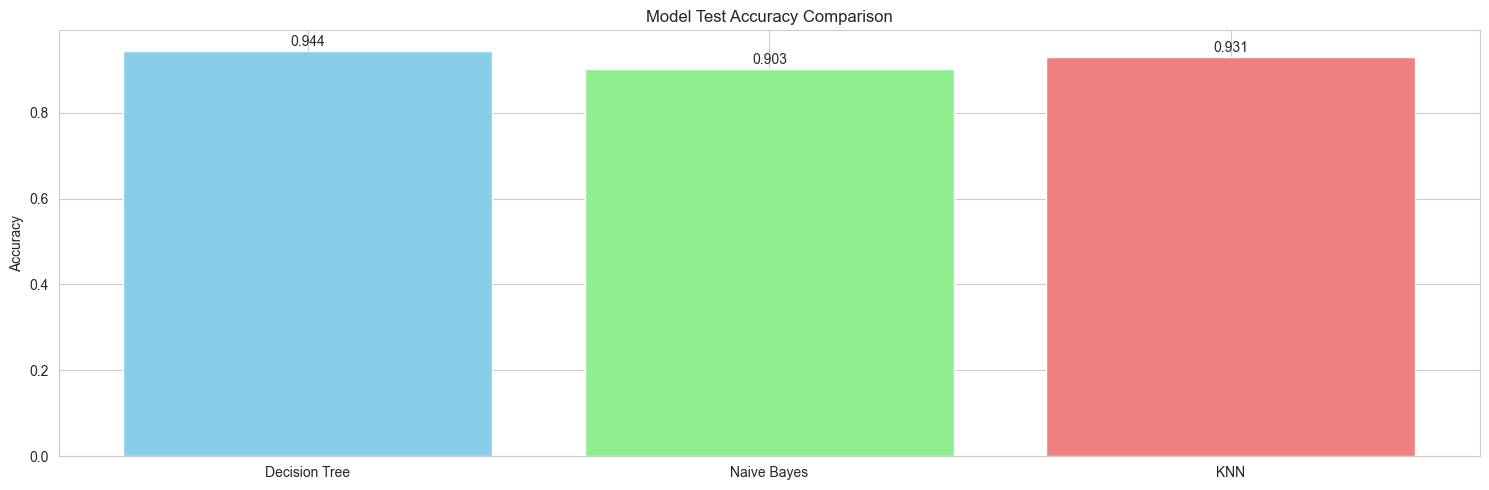

自动调参完成!


In [15]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# 设置图表样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

train_data = map_classes(train_df, True)
test_data = map_classes(test_df, True)

# 参数网格
param_grids = {
    'Decision Tree': {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                      'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
    'Naive Bayes': {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]},
    'KNN': {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
            'weights': ['uniform', 'distance']}
}

# 自动调参
results = {}
for clf_name in classifiers.keys():
    print(f"调参 {clf_name}...")

    grid_search = GridSearchCV(classifiers[clf_name], param_grids[clf_name],
                               cv=5, scoring='accuracy', n_jobs=-1)

    X_train = train_data[features]
    y_train = train_data['Target']

    if clf_name == 'KNN':
        scaler = StandardScaler()
        grid_search.fit(scaler.fit_transform(X_train), y_train)
    else:
        grid_search.fit(X_train, y_train)

    # 用最佳参数创建分类器并评估
    best_clf = grid_search.best_estimator_
    unique_classes, overall_accuracy, class_accuracy = train_and_evaluate(
        train_data, test_data, clf_name, best_clf
    )

    results[clf_name] = {
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'test_accuracy': overall_accuracy
    }

    print(f"最佳参数: {grid_search.best_params_}")
    print(f"测试准确率: {overall_accuracy:.4f}\n")

# 绘制结果
fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

# 第一个图：测试准确率（保持不变）
models = list(results.keys())
test_scores = [results[m]['test_accuracy'] for m in models]
ax1.bar(models, test_scores, color=['skyblue', 'lightgreen', 'lightcoral'])
ax1.set_title('Model Test Accuracy Comparison')
ax1.set_ylabel('Accuracy')
for i, v in enumerate(test_scores):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

print("自动调参完成!")

# 自动调参（多分类）

调参 Decision Tree...
最佳参数: {'max_depth': 8, 'min_samples_split': 2}
测试准确率: 0.7222

调参 Naive Bayes...
最佳参数: {'var_smoothing': 1e-05}
测试准确率: 0.5139

调参 KNN...
最佳参数: {'n_neighbors': 2, 'weights': 'distance'}
测试准确率: 0.7639



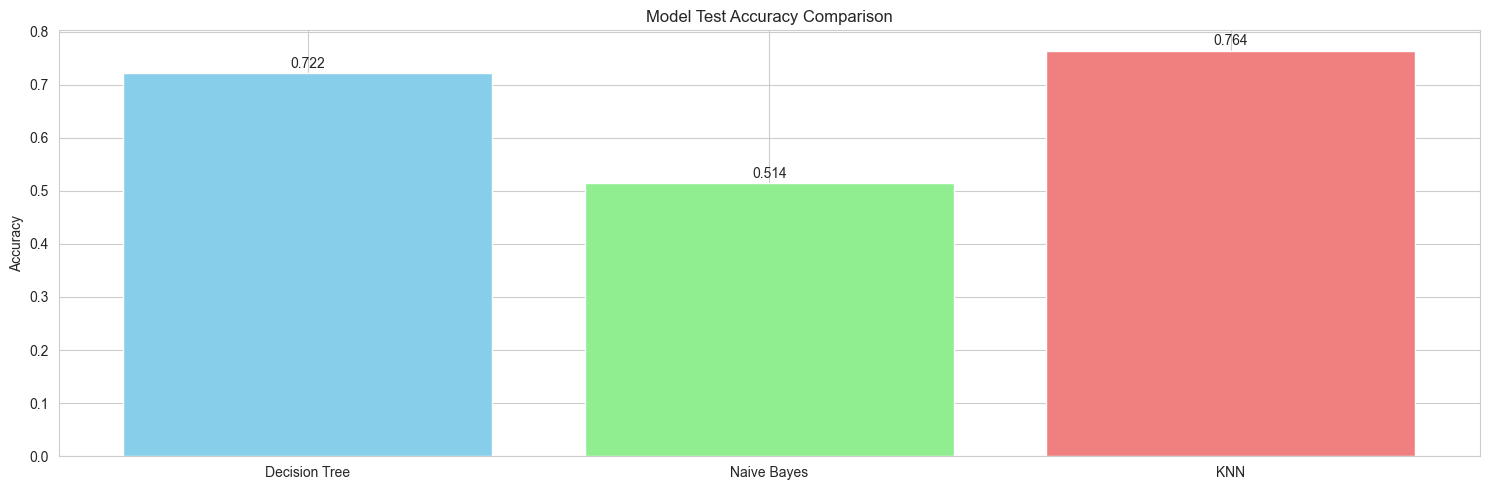

自动调参完成!


In [16]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# 设置图表样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

train_data = map_classes(train_df, False)
test_data = map_classes(test_df, False)

# 参数网格
param_grids = {
    'Decision Tree': {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                      'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
    'Naive Bayes': {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]},
    'KNN': {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
            'weights': ['uniform', 'distance']}
}

# 自动调参
results = {}
for clf_name in classifiers.keys():
    print(f"调参 {clf_name}...")

    grid_search = GridSearchCV(classifiers[clf_name], param_grids[clf_name],
                               cv=5, scoring='accuracy', n_jobs=-1)

    X_train = train_data[features]
    y_train = train_data['Target']

    if clf_name == 'KNN':
        scaler = StandardScaler()
        grid_search.fit(scaler.fit_transform(X_train), y_train)
    else:
        grid_search.fit(X_train, y_train)

    # 用最佳参数创建分类器并评估
    best_clf = grid_search.best_estimator_
    unique_classes, overall_accuracy, class_accuracy = train_and_evaluate(
        train_data, test_data, clf_name, best_clf
    )

    results[clf_name] = {
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'test_accuracy': overall_accuracy
    }

    print(f"最佳参数: {grid_search.best_params_}")
    print(f"测试准确率: {overall_accuracy:.4f}\n")

# 绘制结果
fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

# 第一个图：测试准确率（保持不变）
models = list(results.keys())
test_scores = [results[m]['test_accuracy'] for m in models]
ax1.bar(models, test_scores, color=['skyblue', 'lightgreen', 'lightcoral'])
ax1.set_title('Model Test Accuracy Comparison')
ax1.set_ylabel('Accuracy')
for i, v in enumerate(test_scores):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

print("自动调参完成!")

# 重新设置最佳参数

In [18]:
classifiers = {
    'Decision Tree': DecisionTreeClassifier(max_depth=8, min_samples_split=2, random_state=21),
    'Naive Bayes': GaussianNB(var_smoothing=1e-5),
    'KNN': KNeighborsClassifier(n_neighbors=2, weights='distance'),
}

# soft hard 方法集成

In [27]:
# 补充的集成学习代码
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score


# Hard Voting 集成
def hard_voting_ensemble(train_processed, test_processed, classifiers):
    X_train = train_processed[features]
    y_train = train_processed['Target']
    X_test = test_processed[features]
    y_test = test_processed['Target']

    # 创建投票分类器
    voting_clf = VotingClassifier(
        estimators=[(name, clf) for name, clf in classifiers.items()],
        voting='hard'
    )

    # 标准化处理
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 对于KNN需要使用标准化数据，其他分类器使用原始数据
    # 这里我们使用标准化后的数据进行统一处理
    voting_clf.fit(X_train_scaled, y_train)
    y_pred = voting_clf.predict(X_test_scaled)

    overall_accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)

    unique_classes = sorted(y_test.unique())
    return unique_classes, overall_accuracy, class_accuracy


# Soft Voting
def soft_voting_ensemble(train_processed, test_processed, classifiers):
    X_train = train_processed[features]
    y_train = train_processed['Target']
    X_test = test_processed[features]
    y_test = test_processed['Target']

    # 计算每个分类器的权重（使用交叉验证精度）
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # 创建带权重的软投票分类器
    voting_clf = VotingClassifier(
        estimators=[(name, clf) for name, clf in classifiers.items()],
        voting='soft'
    )

    # 使用标准化数据进行训练和预测
    X_test_scaled = scaler.transform(X_test)
    voting_clf.fit(X_train_scaled, y_train)
    y_pred = voting_clf.predict(X_test_scaled)

    overall_accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)

    unique_classes = sorted(y_test.unique())
    return unique_classes, overall_accuracy, class_accuracy


# 基于交叉验证精度的加权软投票集成
def weighted_soft_voting_ensemble(train_processed, test_processed, classifiers):
    X_train = train_processed[features]
    y_train = train_processed['Target']
    X_test = test_processed[features]
    y_test = test_processed['Target']

    # 标准化数据
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 计算每个分类器的交叉验证精度作为权重
    weights = {}
    cv_results = {}

    # 计算各分类器交叉验证精度
    for clf_name, clf in classifiers.items():
        # 选择合适的数据（KNN用标准化数据，其他用原始数据）
        if clf_name == 'KNN':
            X_data = X_train_scaled
        else:
            X_data = X_train

        # 5折交叉验证获取准确率
        cv_scores = cross_val_score(clf, X_data, y_train, cv=5, scoring='accuracy')
        cv_mean = cv_scores.mean()
        weights[clf_name] = cv_mean
        cv_results[clf_name] = {
            'scores': cv_scores,
            'mean': cv_mean,
            'std': cv_scores.std()
        }
        print(f"{clf_name}: 平均精度 = {cv_mean:.4f} (±{cv_scores.std():.4f})")

    # 创建带权重的软投票分类器
    voting_clf = VotingClassifier(
        estimators=[(name, clf) for name, clf in classifiers.items()],
        voting='soft',
        weights=[weights[name] for name in classifiers.keys()]
    )

    # 输出权重信息
    print("分类器权重:", weights)

    # 训练和预测（使用标准化数据以确保一致性）
    voting_clf.fit(X_train_scaled, y_train)
    y_pred = voting_clf.predict(X_test_scaled)

    overall_accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)

    unique_classes = sorted(y_test.unique())

    return unique_classes, overall_accuracy, class_accuracy


# 比较集成方法
def compare_ensemble_methods(binary=False):
    print(f"\n{'-' * 50}")
    print(f"{'二分类' if binary else '多分类'}任务集成学习比较")

    # 数据处理
    train_processed = map_classes(train_df, binary=binary)
    test_processed = map_classes(test_df, binary=binary)

    # 基准分类器性能
    print("\n基准分类器性能:")
    base_results = {}
    for clf_name, clf in classifiers.items():
        classes, overall_acc, class_acc = train_and_evaluate(train_processed, test_processed, clf_name, clf)
        base_results[clf_name] = overall_acc
        print(f"{clf_name}: {overall_acc:.4f}")

    # Hard Voting 集成
    classes, hard_overall, hard_class = hard_voting_ensemble(train_processed, test_processed, classifiers)
    print(f"Hard Voting 集成: {hard_overall:.4f}\n")

    # Soft Voting 集成
    classes, soft_overall, soft_class = soft_voting_ensemble(train_processed, test_processed, classifiers)
    print(f"Soft Voting 集成: {soft_overall:.4f}\n")

    # 加权 Soft Voting 集成（基于CV精度）
    classes, weighted_overall, weighted_class = weighted_soft_voting_ensemble(
        train_processed, test_processed, classifiers)
    print(f"Soft Voting 集成(加权): {weighted_overall:.4f}\n")

    # 性能比较
    print(f"性能提升分析:")
    best_base = max(base_results.values())
    best_base_name = max(base_results, key=base_results.get)
    print(f"最佳基分类器: {best_base_name} - {best_base:.4f}")
    print(f"Hard Voting 提升: {hard_overall - best_base:+.4f}")
    print(f"Soft Voting 提升: {soft_overall - best_base:+.4f}")
    print(f"Soft Voting(加权) 提升: {weighted_overall - best_base:+.4f}")

    return {
        'base_classifiers': base_results,
        'hard_voting': hard_overall,
        'soft_voting': soft_overall,
        'soft_voting_weighted': weighted_overall
    }


# 二分类任务比较
binary_class_results = compare_ensemble_methods(binary=True)

# 多分类任务比较
multi_class_results = compare_ensemble_methods(binary=False)


--------------------------------------------------
二分类任务集成学习比较

基准分类器性能:
Decision Tree: 0.9444
Naive Bayes: 0.8889
KNN: 0.9306
Hard Voting 集成: 0.9583

Soft Voting 集成: 0.9444

Decision Tree: 平均精度 = 0.9298 (±0.0311)
Naive Bayes: 平均精度 = 0.9229 (±0.0561)
KNN: 平均精度 = 0.9441 (±0.0468)
分类器权重: {'Decision Tree': 0.9298029556650246, 'Naive Bayes': 0.9229064039408866, 'KNN': 0.9440886699507389}
Soft Voting 集成(加权): 0.9444

性能提升分析:
最佳基分类器: Decision Tree - 0.9444
Hard Voting 提升: +0.0139
Soft Voting 提升: +0.0000
Soft Voting(加权) 提升: +0.0000

--------------------------------------------------
多分类任务集成学习比较

基准分类器性能:
Decision Tree: 0.7222
Naive Bayes: 0.5139
KNN: 0.7639
Hard Voting 集成: 0.8056

Soft Voting 集成: 0.7917

Decision Tree: 平均精度 = 0.7182 (±0.0807)
Naive Bayes: 平均精度 = 0.5000 (±0.0887)
KNN: 平均精度 = 0.6840 (±0.0659)
分类器权重: {'Decision Tree': 0.7182266009852216, 'Naive Bayes': 0.4999999999999999, 'KNN': 0.6839901477832513}
Soft Voting 集成(加权): 0.7917

性能提升分析:
最佳基分类器: KNN - 0.7639
Hard Voting 提升: +0.0417
